This notebook demonstrate most of the functionality offered by robpy by applying it to the topgear dataset. Utility function and univariate estimators are not demonstrated separately as they are mostly implemented as helpers to the multivariate estimators.

# Imports

In [18]:
import json

from robpy.datasets import load_topgear
from robpy.preprocessing import DataCleaner, RobustPowerTransformer
from robpy.covariance import FastMCDEstimator, OGKEstimator
from robpy.pca import ROBPCAEstimator
from robpy.outliers import DDCEstimator
from robpy.regression import MMEstimator

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

Robpy has a dataset module which allows the user quick access to a few common datasets used in robust statistics literature. In this demo, we will work with the Topgear dataset.

In [2]:
data = load_topgear(as_frame=True)

print(data.DESCR)

.. _topgear_dataset:

TopGear dataset
--------------------

**Data Set Characteristics:**

- Number of Instances: 297 
- Number of Attributes: 32 (13 numeric, 19 categorical)
- Attribute Information:
    * Maker (str): the car maker.
    * Model (str): the car model.
    * Type (str): the exact model type.
    * Fuel (str): the type of fuel ("Diesel" or "Petrol").
    * Price (float): the list price (in UK pounds)
    * Cylinders (float): the number of cylinders in the engine.
    * Displacement (float): the displacement of the engine (in cc).
    * DriveWheel (str): the type of drive wheel ("4WD", "Front" or "Rear").
    * BHP (float): the power of the engine (in bhp).
    * Torque (float): the torque of the engine (in lb/ft).
    * Acceleration (float): the time it takes the car to get from 0 to 62 mph (in seconds).
    * TopSpeed (float): the car's top speed (in mph).
    * MPG (float): the combined fuel consuption (urban + extra urban; in miles per gallon).
    * Weight (float): th

The `DESCR` attribbute of the data object contains all metadata and a description of the dataset.

In [3]:
data.data.head()

,Maker,Model,Type,Fuel,Price,Cylinders,Displacement,DriveWheel,BHP,Torque,...,ClimateControl,CruiseControl,ElectricSeats,Leather,ParkingSensors,PowerSteering,SatNav,ESP,Verdict,Origin
0,Alfa Romeo,Giulietta,Giulietta 1.6 JTDM-2 105 Veloce 5d,Diesel,21250.0,4.0,1598.0,Front,105.0,236.0,...,standard,standard,optional,optional,optional,standard,optional,standard,6.0,Europe
1,Alfa Romeo,MiTo,MiTo 1.4 TB MultiAir 105 Distinctive 3d,Petrol,15155.0,4.0,1368.0,Front,105.0,95.0,...,optional,standard,no,optional,standard,standard,optional,standard,5.0,Europe
2,Aston Martin,Cygnet,Cygnet 1.33 Standard 3d,Petrol,30995.0,4.0,1329.0,Front,98.0,92.0,...,standard,standard,no,no,no,standard,standard,standard,7.0,Europe
3,Aston Martin,DB9,DB9 6.0 517 Standard 2d 13MY,Petrol,131995.0,12.0,5935.0,Rear,517.0,457.0,...,standard,standard,standard,standard,standard,standard,standard,standard,7.0,Europe
4,Aston Martin,DB9 Volante,DB9 6.0 V12 517 Volante 2d 13MY,Petrol,141995.0,12.0,5935.0,Rear,517.0,457.0,...,standard,standard,standard,standard,standard,standard,standard,standard,7.0,Europe


# Preprocess data

## Cleaning

We use `DataCleaner` to remove non-numeric columns as well as columns and rows with too many missings.

In [8]:
cleaner = DataCleaner().fit(data.data)
clean_data = cleaner.transform(data.data)

We can inspect the dropped columns by type:

In [12]:
print(json.dumps(cleaner.dropped_columns, indent=4))

{
    "non_numeric_cols": [
        "Maker",
        "Model",
        "Type",
        "Fuel",
        "DriveWheel",
        "AdaptiveHeadlights",
        "AdjustableSteering",
        "AlarmSystem",
        "Automatic",
        "Bluetooth",
        "ClimateControl",
        "CruiseControl",
        "ElectricSeats",
        "Leather",
        "ParkingSensors",
        "PowerSteering",
        "SatNav",
        "ESP",
        "Origin"
    ],
    "cols_rownumbers": [],
    "cols_discrete": [
        "Fuel",
        "DriveWheel",
        "AdaptiveHeadlights",
        "AdjustableSteering",
        "AlarmSystem",
        "Automatic",
        "Bluetooth",
        "ClimateControl",
        "CruiseControl",
        "ElectricSeats",
        "Leather",
        "ParkingSensors",
        "PowerSteering",
        "SatNav",
        "ESP",
        "Origin"
    ],
    "cols_bad_scale": [
        "Cylinders"
    ],
    "cols_missings": []
}


As well as the dropped rows:

In [13]:
cleaner.dropped_rows

{'rows_missings': []}

## Transforming

The `Price` variable has a long tail. It's a good idea to apply a power transformation to it

<Axes: >

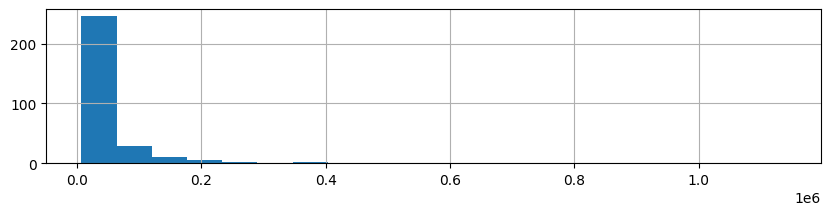

In [16]:
clean_data['Price'].hist(bins=20, figsize=(10, 2))

In [20]:
transformer = RobustPowerTransformer().fit(clean_data['Price'])

clean_data['Price_transformed'] = transformer.transform(clean_data['Price'])

We can inspect which method was selected as well as which lambda value was applied for the transformation:

In [22]:
transformer.method, transformer.lambda_rew

('boxcox', -0.42698150173653826)

<Axes: >

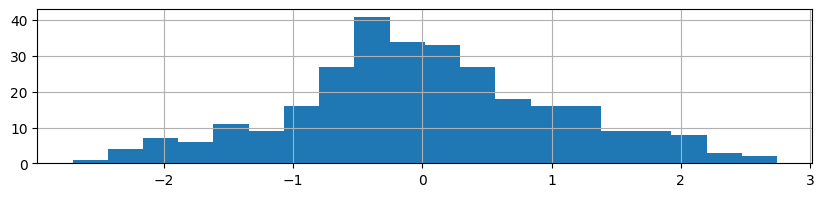

In [21]:
clean_data['Price_transformed'].hist(bins=20, figsize=(10, 2))

# Regression

We can use robust regression to predict the (transformed) price using the remaining variables. For regression, we have to drop all missings.

In [26]:
clean_data2 = clean_data.dropna()
X = clean_data2.drop(columns=['Price', 'Price_transformed'])
y = clean_data2['Price_transformed']

In [34]:
estimator = MMEstimator().fit(X, y)

We can now get a diagnostic plot and ask for the underlying data

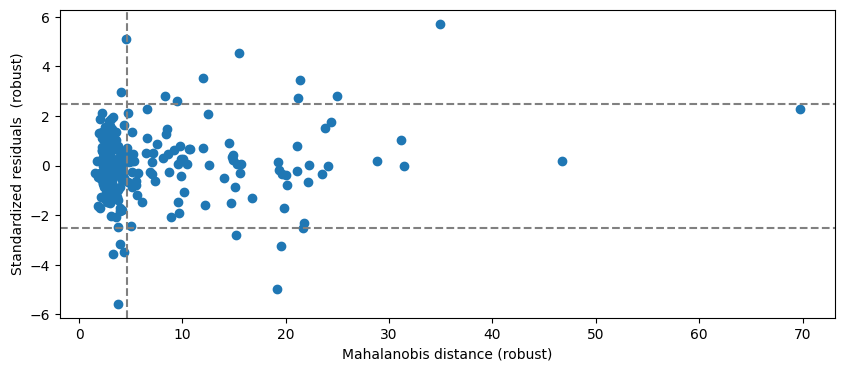

In [61]:
resid, std_resid, distances, vt, ht = estimator.diagnostic_plot(X, y.to_numpy(), return_data=True)

Now we can get an overview of the bad leverage points:

In [66]:
bad_leverage_idx = (np.abs(std_resid) > vt) & (distances > ht)
clean_data2.loc[bad_leverage_idx, :].assign(predicted_price=transformer.inverse_transform(estimator.predict(X.loc[bad_leverage_idx])).round())

,Price,Displacement,BHP,Torque,Acceleration,TopSpeed,MPG,Weight,Length,Width,Height,Verdict,Price_transformed,predicted_price
5,396000.0,5935.0,510.0,420.0,4.2,190.0,17.0,1680.0,4385.0,1865.0,1250.0,7.0,2.347343,97498.0
28,136250.0,3993.0,500.0,487.0,4.7,187.0,25.0,2470.0,4806.0,1920.0,1403.0,8.0,1.716345,482691.0
29,133200.0,5998.0,556.0,479.0,4.9,195.0,17.0,2475.0,5290.0,1920.0,1475.0,8.0,1.699594,395183.0
53,39995.0,6162.0,432.0,419.0,5.6,155.0,20.0,1890.0,4836.0,1918.0,1376.0,6.0,0.530415,88408.0
76,198936.0,4499.0,562.0,398.0,3.4,198.0,21.0,1430.0,4527.0,1937.0,1211.0,10.0,1.973684,79404.0
153,176000.0,3799.0,625.0,442.0,3.1,207.0,24.0,1336.0,4509.0,1908.0,1199.0,9.0,1.894902,71817.0
164,82945.0,2987.0,211.0,398.0,9.1,108.0,25.0,2500.0,4662.0,1760.0,1951.0,3.0,1.309289,43575.0
185,99950.0,4799.0,367.0,370.0,4.5,170.0,26.0,1175.0,4147.0,1751.0,1248.0,8.0,1.472439,33591.0
186,45900.0,3700.0,280.0,282.0,5.5,140.0,28.0,950.0,4010.0,1720.0,1220.0,4.0,0.696613,23457.0
196,990000.0,5980.0,730.0,811.0,3.3,230.0,23.0,1350.0,4605.0,2036.0,1169.0,8.0,2.701395,75717.0
